In [1]:
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
import yfinance as yf
import pandas as pd
import datetime
from sklearn.metrics import mean_squared_error
import time
import math
from sklearn.exceptions import DataConversionWarning
from sklearn import svm
from scipy import stats
import random
import sklearn
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from arch import arch_model
import matplotlib.pyplot as plt
from numba import jit
from sklearn.metrics import mean_squared_error 
import warnings 
warnings.filterwarnings('ignore')
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

In [2]:
def predict_ts(sigma, h):
    # predict square of returns
    l = int(len(sigma)-15)*0.8
    sigma_train, sigma_test =  np.power(sigma[:2400],2), np.power(sigma[2400:],2)
    # reshape to an appropriate forma
    sigma_train = sigma_train.reshape(-1, 1)
    sigma_test = sigma_test.reshape(-1,1)
    
    # scaling to ensure the data is projected in the interval 0,1.
    scaler = MinMaxScaler()
    sigma_train = scaler.fit_transform(sigma_train)
    X_train = sigma_train[:2400-h]
    y_train= sigma_train[h:]
    X_test = sigma_test[:616-h]
    y_test = sigma_test[h:]
    
    warnings.filterwarnings('ignore', category=DataConversionWarning)
    
    param_grid = {'C': [0.1, 1], 'gamma': [1,'auto', 'scale', 10],'kernel': ['rbf','poly', 'sigmoid']}
    grid = GridSearchCV(SVR(), param_grid, refit=True, verbose=1)
    grid.fit(X_train,y_train)
    svr = grid.best_estimator_
    print(svr)

    svr.fit(X_train,y_train)
    p = svr.predict(X_test)
    predictions = scaler.inverse_transform(np.array(p).reshape(-1, 1))
    error = mean_squared_error(y_test, predictions)
    return error

In [3]:
def garch22(ret, sigma, h):
    l = int(len(sigma)-15)*0.8
    ret_train, ret_test, sigma_train, sigma_test = ret[:2400],ret[2400:], sigma[:2400],sigma[2400:]
    pred = []
    real = []
    k = len(ret_test)
    warnings.filterwarnings('ignore')
     # fit a built-in function to estimate coefficients 
    garch = arch_model(ret_train, p=2, q=2).fit(disp='off')
    #read coefficients 
    omega,a1,b1,a2,b2 = (garch.params['omega'], garch.params['alpha[1]'],
                              garch.params['beta[1]'], garch.params['alpha[2]'], garch.params['beta[2]'])
    
    for i in range(k):

        #calculate sigma square
        pred_sigma2 =(omega* ((1-np.power(a1+b1, h-1))/(1-a1-b1)+(1-np.power(a2+b2, h-2))/(1-a2-b2))
                      + np.power(a1+b1,h)* sigma_train[-h]**2 + np.power(a2+b2,h-2)* sigma_train[-h]**2)
        
        pred.append(pred_sigma2)
        real.append(sigma_test[0]**2)
        
        ret_train = np.append(ret_train, ret_test[0])
        ret_test = np.delete(ret_test, [0])
        sigma_train = np.append(sigma_train, sigma_test[0])
        sigma_test = np.delete(sigma_test, [0])

    mse_garch2 = mean_squared_error(pred, real)
    
    return mse_garch2

In [4]:
def garch11(ret, sigma, h):
    l = int(len(sigma)-15)*0.8
    ret_train, ret_test, sigma_train, sigma_test = ret[:2404],ret[2400:], sigma[:2400],sigma[2400:]

    pred = []
    real = []
    k = len(ret_test)
    # fit a built-in function to estimate coefficients 
    garch = arch_model(ret_train, p=1, q=1).fit(disp='off')
    #read coefficients 
    omega,a1,b1 = garch.params['omega'], garch.params['alpha[1]'], garch.params['beta[1]']
    
    
    for i in range(k):

        #calculate sigma square
        pred_sigma2 = omega* (1-np.power(a1+b1, h-1))/(1-a1-b1) + np.power(a1+b1,h)* sigma_train[-h]**2
        
        pred.append(pred_sigma2)
        real.append(sigma_test[0]**2)
        #print(pred_sigma2, sigma_test[0]**2)
        ret_train = np.append(ret_train, ret_test[0])
        ret_test = np.delete(ret_test, [0])
        sigma_train = np.append(sigma_train, sigma_test[0])
        sigma_test = np.delete(sigma_test, [0])



    mse_garch1 = mean_squared_error(pred,real)
    return mse_garch1

In [5]:
def rf_predict(sigma, h):
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    sigma_train, sigma_test =  np.power(sigma[:2400],2), np.power(sigma[2400:],2)
    # reshape to an appropriate forma
    sigma_train = sigma_train.reshape(-1, 1)
    sigma_test = sigma_test.reshape(-1,1)
    
    # scaling to ensure the data is projected in the interval 0,1.
    scaler = MinMaxScaler()
    sigma_train = scaler.fit_transform(sigma_train)
    X_train = sigma_train[:2400-h]
    y_train= sigma_train[h:]
    X_test = sigma_test[:616-h]
    y_test = sigma_test[h:]
    
    warnings.filterwarnings('ignore', category=DataConversionWarning)
    rf = RandomForestRegressor()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                                   n_iter = 100, cv = 3, verbose=1, random_state=42, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(X_train, y_train.ravel())
    print(rf_random.best_estimator_)
    rf = rf_random.best_estimator_
    p = rf.predict(X_test)
    predictions = scaler.inverse_transform(np.array(p).reshape(-1, 1))
    error = mean_squared_error(y_test, predictions)
    
    return error

In [6]:
SP500 = yf.download('SPY', start = '2010-01-01', end='2022-1-1')

[*********************100%***********************]  1 of 1 completed


In [7]:
SP500['Daily Return'] = SP500['Adj Close'].pct_change(1)
returns = SP500['Daily Return'].dropna().values
returns = returns[4:]
SP500['Adj Daily Return'] = SP500['Daily Return'] - SP500['Daily Return'].mean()
realized_vol = SP500['Adj Daily Return'].rolling(5).std().dropna().values

In [8]:
l = int((len(realized_vol)-15)*0.8)
print(l)

2400


In [9]:
print(len(returns)-l)

616


In [10]:
err_1 = []
err_2 = []
err_svr = []
err_rf = []

for h in range(2,25):
    err_1.append(garch11(returns, realized_vol, h))
    err_2.append(garch22(returns, realized_vol, h))
    err_svr.append(predict_ts(realized_vol,h))
    err_rf.append(rf_predict(realized_vol, h))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
SVR(C=1, gamma=1, kernel='sigmoid')
Fitting 3 folds for each of 100 candidates, totalling 300 fits
RandomForestRegressor(bootstrap=False, max_depth=10, min_samples_leaf=4,
                      min_samples_split=5, n_estimators=200)
Fitting 5 folds for each of 24 candidates, totalling 120 fits
SVR(C=1, gamma=1, kernel='sigmoid')
Fitting 3 folds for each of 100 candidates, totalling 300 fits
RandomForestRegressor(bootstrap=False, max_depth=10, min_samples_leaf=4,
                      min_samples_split=5, n_estimators=200)
Fitting 5 folds for each of 24 candidates, totalling 120 fits
SVR(C=1, gamma=1, kernel='sigmoid')
Fitting 3 folds for each of 100 candidates, totalling 300 fits
RandomForestRegressor(bootstrap=False, max_depth=10, min_samples_leaf=4,
                      min_samples_split=5, n_estimators=200)
Fitting 5 folds for each of 24 candidates, totalling 120 fits
SVR(C=0.1, gamma=10, kernel='sigmoid')
Fitting 3 fold

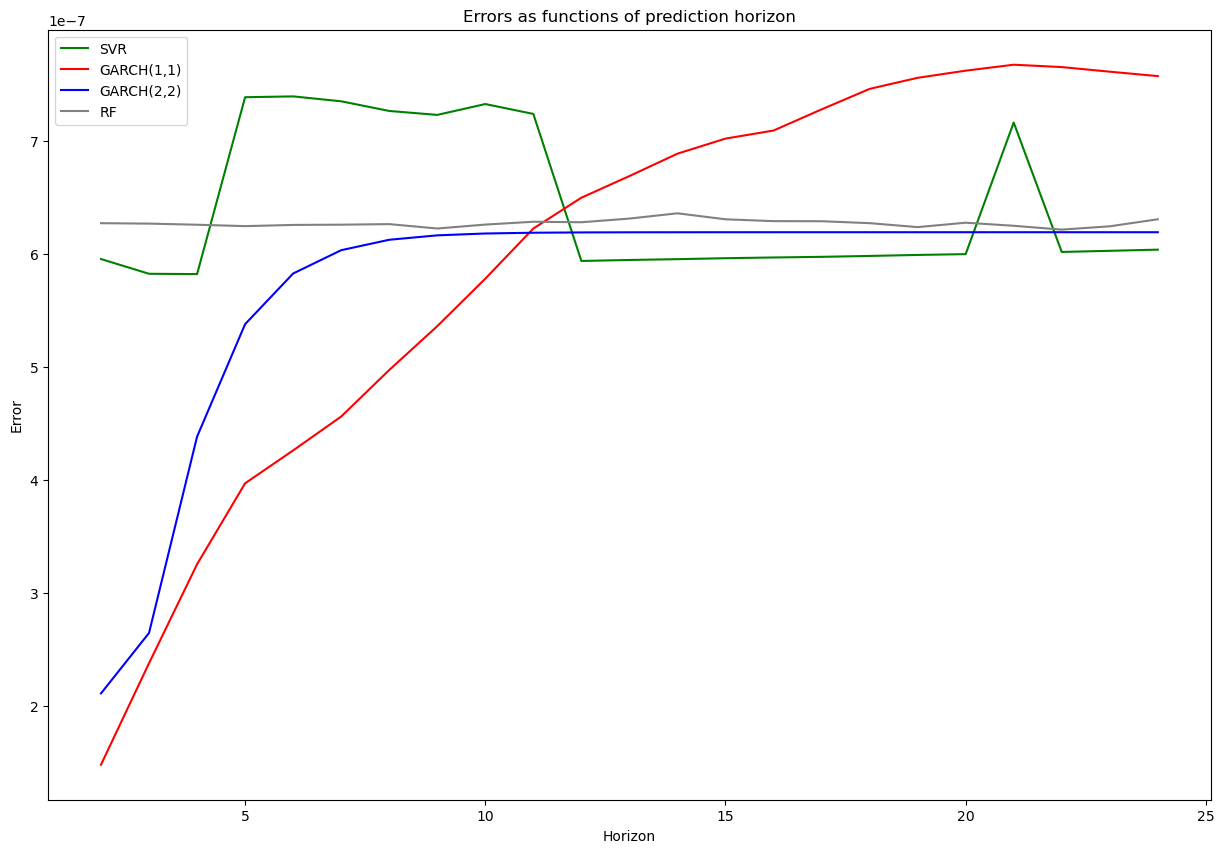

In [11]:
plt.figure(figsize=(15, 10))
plt.plot(range(2,25),err_svr,color='green', label='SVR') 
plt.plot(range(2,25),err_1,color='red', label="GARCH(1,1)") 
plt.plot(range(2,25),err_2,color='blue', label="GARCH(2,2)") 
plt.plot(range(2,25),err_rf,color='gray', label='RF') 
plt.title('Errors as functions of prediction horizon') 
plt.ylabel('Error') 
plt.xlabel('Horizon') 
plt.legend()
plt.show()

In [12]:
MOEX = yf.download('MOEX.ME', start = '2010-01-01', end='2022-1-1')

[*********************100%***********************]  1 of 1 completed


In [13]:
MOEX['Daily Return'] = MOEX['Adj Close'].pct_change(1)
returns = MOEX['Daily Return'].dropna().values
returns1 = returns[4:]
MOEX['Adj Daily Return'] = MOEX['Daily Return'] - MOEX['Daily Return'].mean()
realized_vol1 = MOEX['Adj Daily Return'].rolling(5).std().dropna().values

In [14]:
l = int((len(realized_vol)-15)*0.8)
print(l)

2400


In [15]:
print(len(returns)-l)

-171


In [16]:
def predict_ts1(sigma, h):
    # predict square of returns
    l = int(len(sigma)-15)*0.8
    sigma_train, sigma_test =  np.power(sigma[:1768],2), np.power(sigma[1768:],2)
    # reshape to an appropriate forma
    sigma_train = sigma_train.reshape(-1, 1)
    sigma_test = sigma_test.reshape(-1,1)
    
    # scaling to ensure the data is projected in the interval 0,1.
    scaler = MinMaxScaler()
    sigma_train = scaler.fit_transform(sigma_train)
    X_train = sigma_train[:1768-h]
    y_train= sigma_train[h:]
    X_test = sigma_test[:457-h]
    y_test = sigma_test[h:]
    
    warnings.filterwarnings('ignore', category=DataConversionWarning)
    
    param_grid = {'C': [0.1, 1], 'gamma': [1,'auto', 'scale', 10],'kernel': ['rbf','poly', 'sigmoid']}
    grid = GridSearchCV(SVR(), param_grid, refit=True, verbose=1)
    grid.fit(X_train,y_train)
    svr = grid.best_estimator_
    print(svr)

    svr.fit(X_train,y_train)
    p = svr.predict(X_test)
    predictions = scaler.inverse_transform(np.array(p).reshape(-1, 1))
    error = mean_squared_error(y_test, predictions)
    return error

In [17]:
def garch111(ret, sigma, h):
    l = int(len(sigma)-15)*0.8
    ret_train, ret_test, sigma_train, sigma_test = ret[:1768],ret[1768:], sigma[:1768],sigma[1768:]

    pred = []
    real = []
    k = len(ret_test)
    # fit a built-in function to estimate coefficients 
    garch = arch_model(ret_train, p=1, q=1).fit(disp='off')
    #read coefficients 
    omega,a1,b1 = garch.params['omega'], garch.params['alpha[1]'], garch.params['beta[1]']
    
    
    for i in range(k):

        #calculate sigma square
        pred_sigma2 = omega* (1-np.power(a1+b1, h-1))/(1-a1-b1) + np.power(a1+b1,h)* sigma_train[-h]**2
        
        pred.append(pred_sigma2)
        real.append(sigma_test[0]**2)
        #print(pred_sigma2, sigma_test[0]**2)
        ret_train = np.append(ret_train, ret_test[0])
        ret_test = np.delete(ret_test, [0])
        sigma_train = np.append(sigma_train, sigma_test[0])
        sigma_test = np.delete(sigma_test, [0])



    mse_garch1 = mean_squared_error(pred,real)
    return mse_garch1

In [18]:
def garch221(ret, sigma, h):
    l = int(len(sigma)-15)*0.8
    ret_train, ret_test, sigma_train, sigma_test = ret[:1768],ret[1768:], sigma[:1768],sigma[1768:]
    pred = []
    real = []
    k = len(ret_test)
    warnings.filterwarnings('ignore')
     # fit a built-in function to estimate coefficients 
    garch = arch_model(ret_train, p=2, q=2).fit(disp='off')
    #read coefficients 
    omega,a1,b1,a2,b2 = (garch.params['omega'], garch.params['alpha[1]'],
                              garch.params['beta[1]'], garch.params['alpha[2]'], garch.params['beta[2]'])
    
    for i in range(k):

        #calculate sigma square
        pred_sigma2 =(omega* ((1-np.power(a1+b1, h-1))/(1-a1-b1)+(1-np.power(a2+b2, h-2))/(1-a2-b2))
                      + np.power(a1+b1,h)* sigma_train[-h]**2 + np.power(a2+b2,h-2)* sigma_train[-h]**2)
        
        pred.append(pred_sigma2)
        real.append(sigma_test[0]**2)
        
        ret_train = np.append(ret_train, ret_test[0])
        ret_test = np.delete(ret_test, [0])
        sigma_train = np.append(sigma_train, sigma_test[0])
        sigma_test = np.delete(sigma_test, [0])

    mse_garch2 = mean_squared_error(pred, real)
    
    return mse_garch2

In [21]:
def rf_predict1(sigma, h):
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    sigma_train, sigma_test =  np.power(sigma[:1768],2), np.power(sigma[1768:],2)
    # reshape to an appropriate forma
    sigma_train = sigma_train.reshape(-1, 1)
    sigma_test = sigma_test.reshape(-1,1)
    
    # scaling to ensure the data is projected in the interval 0,1.
    scaler = MinMaxScaler()
    sigma_train = scaler.fit_transform(sigma_train)
    X_train = sigma_train[:1768-h]
    y_train= sigma_train[h:]
    X_test = sigma_test[:457-h]
    y_test = sigma_test[h:]
    
    warnings.filterwarnings('ignore', category=DataConversionWarning)
    rf = RandomForestRegressor()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                                   n_iter = 100, cv = 3, verbose=1, random_state=42, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(X_train, y_train.ravel())
    print(rf_random.best_estimator_)
    rf = rf_random.best_estimator_
    p = rf.predict(X_test)
    predictions = scaler.inverse_transform(np.array(p).reshape(-1, 1))
    error = mean_squared_error(y_test, predictions)
    
    return error

In [22]:
err_1 = []
err_2 = []
err_svr = []
err_rf = []

for h in range(2,25):
    err_1.append(garch111(returns1, realized_vol1, h))
    err_2.append(garch221(returns1, realized_vol1, h))
    err_svr.append(predict_ts1(realized_vol1,h))
    err_rf.append(rf_predict1(realized_vol1, h))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
SVR(C=1, gamma=1, kernel='sigmoid')
Fitting 3 folds for each of 100 candidates, totalling 300 fits
RandomForestRegressor(bootstrap=False, max_depth=10, min_samples_leaf=4,
                      min_samples_split=5, n_estimators=200)
Fitting 5 folds for each of 24 candidates, totalling 120 fits
SVR(C=1, gamma=1, kernel='sigmoid')
Fitting 3 folds for each of 100 candidates, totalling 300 fits
RandomForestRegressor(bootstrap=False, max_depth=10, min_samples_leaf=4,
                      min_samples_split=5, n_estimators=200)
Fitting 5 folds for each of 24 candidates, totalling 120 fits
SVR(C=1, gamma=1, kernel='sigmoid')
Fitting 3 folds for each of 100 candidates, totalling 300 fits
RandomForestRegressor(bootstrap=False, max_depth=10, min_samples_leaf=4,
                      min_samples_split=5, n_estimators=200)
Fitting 5 folds for each of 24 candidates, totalling 120 fits
SVR(C=1, gamma=1, kernel='sigmoid')
Fitting 3 folds f

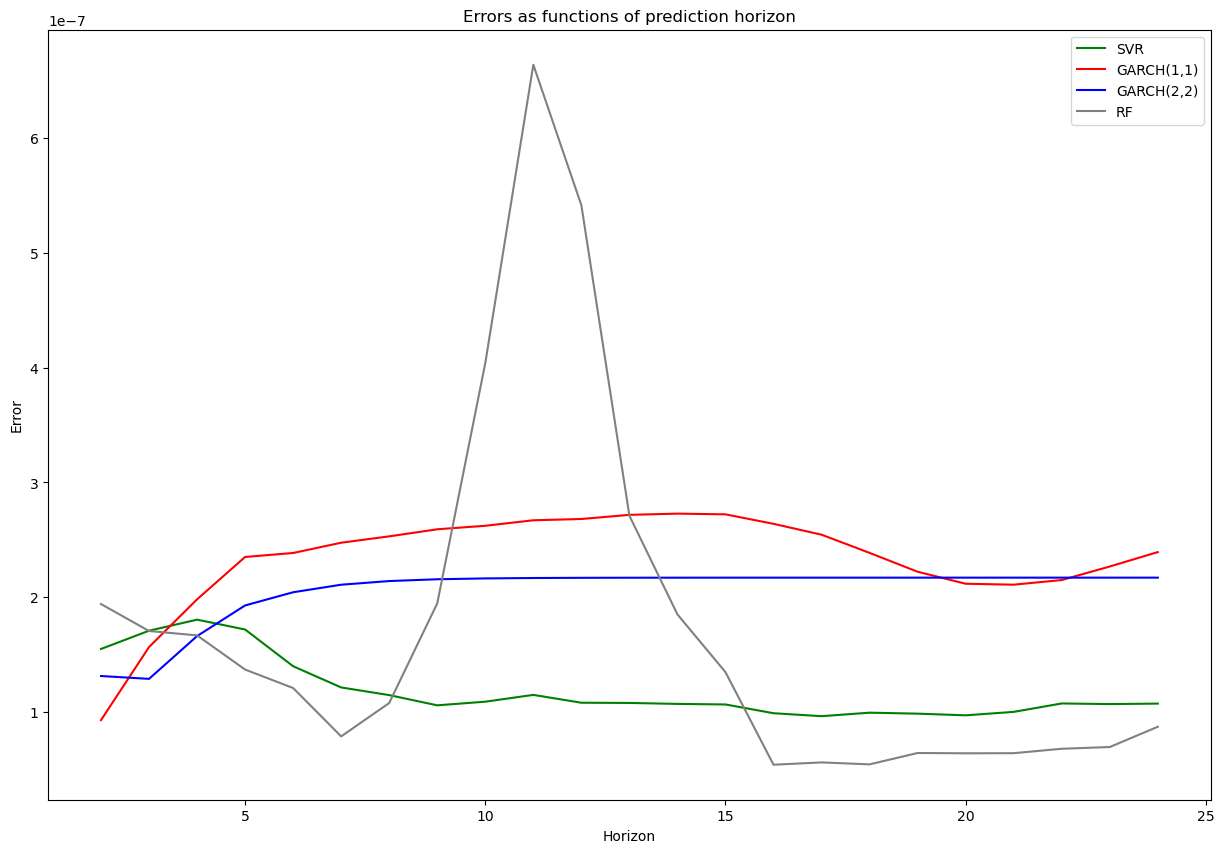

In [23]:
plt.figure(figsize=(15, 10))
plt.plot(range(2,25),err_svr,color='green', label='SVR') 
plt.plot(range(2,25),err_1,color='red', label="GARCH(1,1)") 
plt.plot(range(2,25),err_2,color='blue', label="GARCH(2,2)") 
plt.plot(range(2,25),err_rf,color='gray', label='RF') 
plt.title('Errors as functions of prediction horizon') 
plt.ylabel('Error') 
plt.xlabel('Horizon') 
plt.legend()
plt.show()